In [1]:
import numpy as np
import tensorflow as tf 
import os 
from tensorflow import keras 
import pandas as pd
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
import keras.backend as kb
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import  ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
input_path= "/content/drive/My Drive/Pneumonia_detection/chest_xray/"

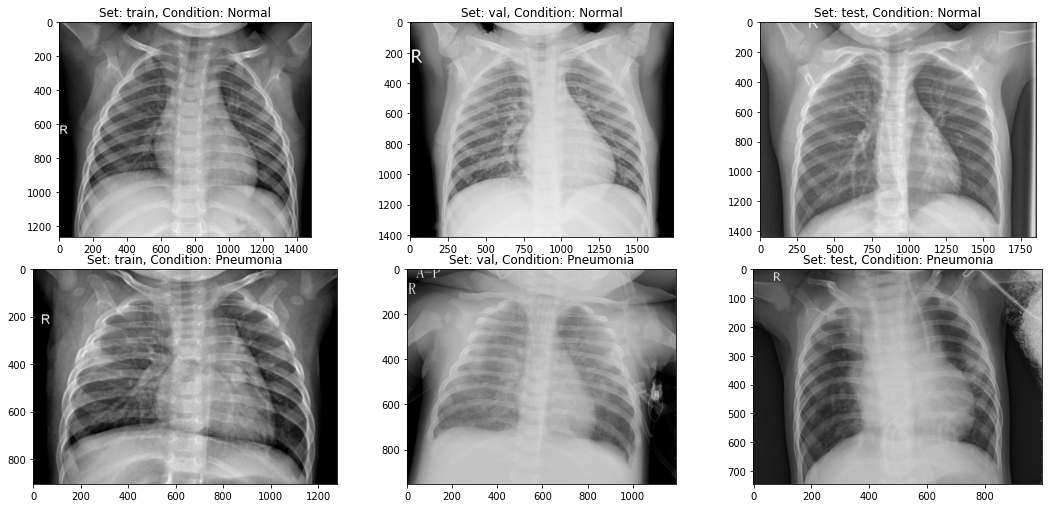

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(15,7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
  set_path = input_path +_set
  ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap= 'gray')
  ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
  ax[i+3].imshow(plt.imread(set_path+ '/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
  ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

Creation du Data generator

In [6]:
def data_processing(dims, batch_size):
  #Data generator 
  train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
  test_datagen = ImageDataGenerator(rescale=1./255)


  train_gen = train_datagen.flow_from_directory(
      directory =input_path + 'train',
      target_size = (dims, dims),
      batch_size = batch_size,
      class_mode = 'binary',
      shuffle =True)
  

  test_gen = test_datagen.flow_from_directory(
      directory = input_path + 'test',
      target_size = (dims, dims),
      batch_size = batch_size,
      class_mode = 'binary',
      shuffle= True )


  test_data = []
  test_labels = []

  for i in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path+ 'test'+ i)):
      img = plt.imread(input_path+ 'test'+ i+ img)
      img= cv2.resize(img, (dims, dims))
      img = np.dstack([img, img, img])
      img = img.astype('float32')/ 255
      if i == '/NORMAL/':
        label = 0
      elif i == '/PNEUMONIA/':
        label = 1
      test_data.append(img)
      test_labels.append(label)

  test_data = np.array(test_data)
  test_labels = np.array(test_labels)

  return train_gen, test_gen, test_data, test_labels

In [8]:
# Appels de notre  fonction data processing

dims = 150
epochs= 30
batch_size = 32
train_gen, test_gen, test_data, test_labels= data_processing(dims, batch_size)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
 # Creation du model 
 inputs = Input(shape= (dims, dims, 3))

 # Premier block
 x = Conv2D(filters = 16, kernel_size=(3, 3), activation='relu', padding= 'same')(inputs)
 x = Conv2D(filters=16, kernel_size=(3, 3), activation ='relu', padding='same')(x)
 x = MaxPool2D(pool_size= (2,2))(x)

 # block 2
 x= SeparableConv2D(filters=32, kernel_size= (3, 3), activation='relu', padding='same')(x)
 x =SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = MaxPool2D(pool_size=(2, 2))(x)

 # block 3
 x = SeparableConv2D(filters= 64, kernel_size=(3,3), activation= 'relu', padding='same')(x)
 x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation= 'relu', padding = 'same' )(x)
 x = BatchNormalization()(x)
 x = MaxPool2D(pool_size=(2,2))(x)

 # Quatrieme block
 x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
 x = SeparableConv2D(filters =128, kernel_size=(3, 3), activation ='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = MaxPool2D(pool_size=(2, 2))(x)
 x = Dropout(rate= 0.2)(x)

 # block 5
 x = SeparableConv2D(filters =256, kernel_size= (3, 3), activation ='relu', padding='same')(x)
 x = SeparableConv2D(filters=256, kernel_size= (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = MaxPool2D(pool_size=(2,2))(x)
 x = Dropout(rate = 0.2)(x)

 #layer
 x = Flatten()(x)
 x= Dense(units=512, activation='relu')(x)
 x= Dropout(rate=0.7)(x)
 x= Dense(units= 128, activation='relu')(x)
 x= Dropout(rate=0.5)(x)
 x= Dense(units=64, activation='relu')(x)
 x= Dropout(rate=0.3)(x)

 #Output layer
 output = Dense(units=1, activation='sigmoid')(x)
 
 # Creation du modele et compilation
 model = Model(inputs=inputs, outputs= output)
 model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'])

 #callbacks
 checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
 lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose= 2, mode='max')
 early_stop = EarlyStopping(monitor= 'val_loss', min_delta= 0.1, patience=1, mode= 'min')


In [12]:
import pickle 
MODEL_FILE= "/content/drive/My Drive/Pneumonia_detection/Model/model.h5"

In [13]:
hist = model.fit(
    train_gen, steps_per_epoch = train_gen.samples // batch_size,
    epochs = epochs, validation_data = test_gen,
    validation_steps = test_gen.samples // batch_size, callbacks= [checkpoint, lr_reduce])


Epoch 1/30
163/163 [==============================] - 1186s 7s/step - loss: 0.3764 - accuracy: 0.8160 - val_loss: 0.6797 - val_accuracy: 0.6266
Epoch 2/30
163/163 [==============================] - 83s 506ms/step - loss: 0.2884 - accuracy: 0.8837 - val_loss: 0.7721 - val_accuracy: 0.3766
Epoch 3/30
163/163 [==============================] - 83s 509ms/step - loss: 0.2848 - accuracy: 0.8837 - val_loss: 0.6957 - val_accuracy: 0.3799
Epoch 4/30
163/163 [==============================] - 85s 519ms/step - loss: 0.2646 - accuracy: 0.8904 - val_loss: 1.0862 - val_accuracy: 0.3734
Epoch 5/30
163/163 [==============================] - 85s 523ms/step - loss: 0.2460 - accuracy: 0.9027 - val_loss: 1.6255 - val_accuracy: 0.3750
Epoch 6/30
163/163 [==============================] - 87s 532ms/step - loss: 0.2317 - accuracy: 0.9088 - val_loss: 1.0657 - val_accuracy: 0.5362
Epoch 7/30
163/163 [==============================] - ETA: 0s - loss: 0.2071 - accuracy: 0.9219
Epoch 00007: ReduceLROnPlateau redu

In [ ]:
##with open(MODEL_FILE, 'wb') as file2:
  #pickle.dump(model, file2)

model.save(MODEL_FILE)

In [ ]:
test_data[0].shape

(150, 150, 3)

In [ ]:
from sklearn.metrics import  accuracy_score, confusion_matrix
preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))



CONFUSION MATRIX ------------------
[[194  40]
 [ 10 380]]

TEST METRICS ----------------------
Accuracy: 91.98717948717949%
Precision: 90.47619047619048%
Recall: 97.43589743589743%
F1-score: 93.82716049382717


In [ ]:
my_model = tf.keras.models.load_model(MODEL_FILE)

In [ ]:
test_normal = "/content/drive/My Drive/Pneumonia_detection/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg"
test_pneumonia = "/content/drive/My Drive/Pneumonia_detection/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg"

In [ ]:
def prediction(img, model):
  img = plt.imread(img)
  img= cv2.resize(img, (150, 150))
  img = np.dstack([img, img, img])
  img = img.astype('float32')/ 255
  img = np.array(img)
  img = img.reshape([1]+list(img.shape))
  preds = model.predict(img)
  return preds



In [ ]:
x = prediction(test_normal, my_model)
x

array([[0.8903813]], dtype=float32)